In [30]:
import pandas as pd
df = pd.read_csv('/Users/mohaksharma/Documents/Data Science/DSE 501/Project/tourism_dataset.csv')

In [31]:
# Preview the dataset
df.head()

# Check for missing values and data types
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5989 entries, 0 to 5988
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Location                 5989 non-null   object 
 1   Country                  5989 non-null   object 
 2   Category                 5989 non-null   object 
 3   Visitors                 5989 non-null   int64  
 4   Rating                   5989 non-null   float64
 5   Revenue                  5989 non-null   float64
 6   Accommodation_Available  5989 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 327.7+ KB


Location                   0
Country                    0
Category                   0
Visitors                   0
Rating                     0
Revenue                    0
Accommodation_Available    0
dtype: int64

In [32]:
# Convert 'Accommodation_Available' to binary (Yes -> 1, No -> 0)
df['Accommodation_Available'] = df['Accommodation_Available'].map({'Yes': 1, 'No': 0})

# Ensure correct numeric types (already mostly okay)
df['Visitors'] = df['Visitors'].astype(int)
df['Rating'] = df['Rating'].astype(float)
df['Revenue'] = df['Revenue'].astype(float)

## Tourism Diversity Index (TDI) Formula

The Tourism Diversity Index (TDI) is calculated as:

$$
TDI = 1 - \sum_{i=1}^{n} s_i^2
$$

Where:

- $s_i$ is the proportion of tourism entries in category $i$ within a country  
- $n$ is the total number of unique tourism categories

**Interpretation:**

- If $TDI \to 1$, the tourism categories are **evenly distributed** → high diversity  
- If $TDI \to 0$, a few categories **dominate** → low diversity

In [33]:
def calculate_tdi(data):
    tdi_scores = {}
    for country in data['Country'].unique():
        subset = data[data['Country'] == country]
        proportions = subset['Category'].value_counts(normalize=True)
        si_squared = (proportions**2).sum()
        tdi_scores[country] = 1 - si_squared
    return pd.DataFrame.from_dict(tdi_scores, orient='index', columns=['TDI'])

tdi_df = calculate_tdi(df)
tdi_df = tdi_df.sort_values(by='TDI', ascending=False)
tdi_df.head()

,TDI
China,0.833230
India,0.832963
Australia,0.832838
Egypt,0.832448
USA,0.832227


In [34]:
# Step: Add Revenue-per-Visitor
df['Revenue_per_visitor'] = df['Revenue'] / df['Visitors']

# Group by Country and Category for CPS
grouped = df.groupby(['Country', 'Category']).agg({
    'Revenue_per_visitor': 'mean',
    'Rating': 'mean',
    'Accommodation_Available': 'mean'
}).reset_index()

# Normalize each CPS component
for col in ['Revenue_per_visitor', 'Rating', 'Accommodation_Available']:
    grouped[col] = (grouped[col] - grouped[col].min()) / (grouped[col].max() - grouped[col].min())

# Final CPS calculation
grouped['CPS'] = grouped[['Revenue_per_visitor', 'Rating', 'Accommodation_Available']].mean(axis=1)
grouped.sort_values(by='CPS', ascending=False).head()

,Country,Category,Revenue_per_visitor,Rating,Accommodation_Available,CPS
10,Brazil,Nature,0.720324,0.841328,0.850808,0.804153
9,Brazil,Historical,0.893437,0.453091,0.997773,0.781434
1,Australia,Beach,0.593398,0.946982,0.566786,0.702389
37,USA,Beach,0.155454,0.756282,0.994683,0.635473
22,Egypt,Nature,0.235504,0.563725,1.000000,0.599743


In [35]:
# Count how often each (Country, Category) appears
category_counts = df.groupby(['Country', 'Category']).size().reset_index(name='Count')

# Merge with CPS
final_df = grouped.merge(category_counts, on=['Country', 'Category'])


In [36]:
print("Min CPS:", final_df['CPS'].min())
print("Max CPS:", final_df['CPS'].max())
print("CPS > 0.5 count:", (final_df['CPS'] > 0.5).sum())
print("CPS > 0.6 count:", (final_df['CPS'] > 0.6).sum())
print("CPS > 0.7 count:", (final_df['CPS'] > 0.7).sum())

Min CPS: 0.1557498673400757
Max CPS: 0.8041533576718236
CPS > 0.5 count: 9
CPS > 0.6 count: 4
CPS > 0.7 count: 3


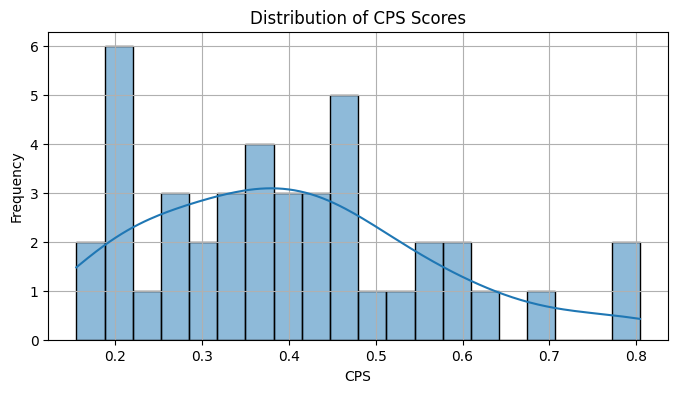

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(final_df['CPS'], bins=20, kde=True)
plt.title('Distribution of CPS Scores')
plt.xlabel('CPS')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
# Define the 90th percentile threshold for CPS
cps_90 = final_df['CPS'].quantile(0.90)

# Market gap: high CPS by quantile + low representation
gaps = final_df[(final_df['CPS'] >= cps_90) & (final_df['Count'] < 10)]
gaps = gaps.sort_values(by='CPS', ascending=False)

In [39]:
top_recommendations = final_df.sort_values(by='CPS', ascending=False).head(5)
display(top_recommendations)

,Country,Category,Revenue_per_visitor,Rating,Accommodation_Available,CPS,Count
10,Brazil,Nature,0.720324,0.841328,0.850808,0.804153,116
9,Brazil,Historical,0.893437,0.453091,0.997773,0.781434,148
1,Australia,Beach,0.593398,0.946982,0.566786,0.702389,148
37,USA,Beach,0.155454,0.756282,0.994683,0.635473,124
22,Egypt,Nature,0.235504,0.563725,1.000000,0.599743,129


In [40]:
# Merge TDI into the CPS dataframe
tdi_df = calculate_tdi(df).reset_index().rename(columns={'index': 'Country'})
final_df_with_tdi = pd.merge(final_df, tdi_df, on='Country', how='left')

# Select top 10 by CPS
top_10 = final_df_with_tdi.sort_values(by='CPS', ascending=False).head(10)

# Final cleaned-up table
recommendation_table = top_10[[
    'Country', 'TDI', 'Category', 'CPS', 'Count', 'Rating', 'Revenue_per_visitor', 'Accommodation_Available'
]].rename(columns={
    'TDI': 'Tourism Diversity Index (TDI)',
    'Category': 'Tourism Category',
    'CPS': 'Potential Score (CPS)',
    'Count': 'Representation Count',
    'Rating': 'Average Rating',
    'Revenue_per_visitor': 'Revenue per Visitor',
    'Accommodation_Available': 'Accommodation Availability Rate'
})

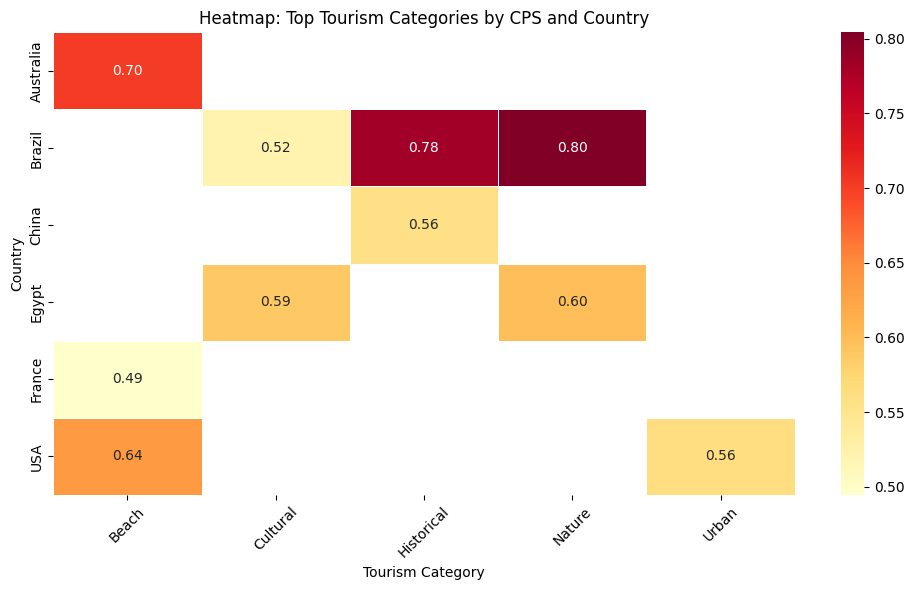

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Heatmap of CPS by Country and Category
heatmap_data = recommendation_table.pivot(index='Country', columns='Tourism Category', values='Potential Score (CPS)')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
plt.title('Heatmap: Top Tourism Categories by CPS and Country')
plt.ylabel('Country')
plt.xlabel('Tourism Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

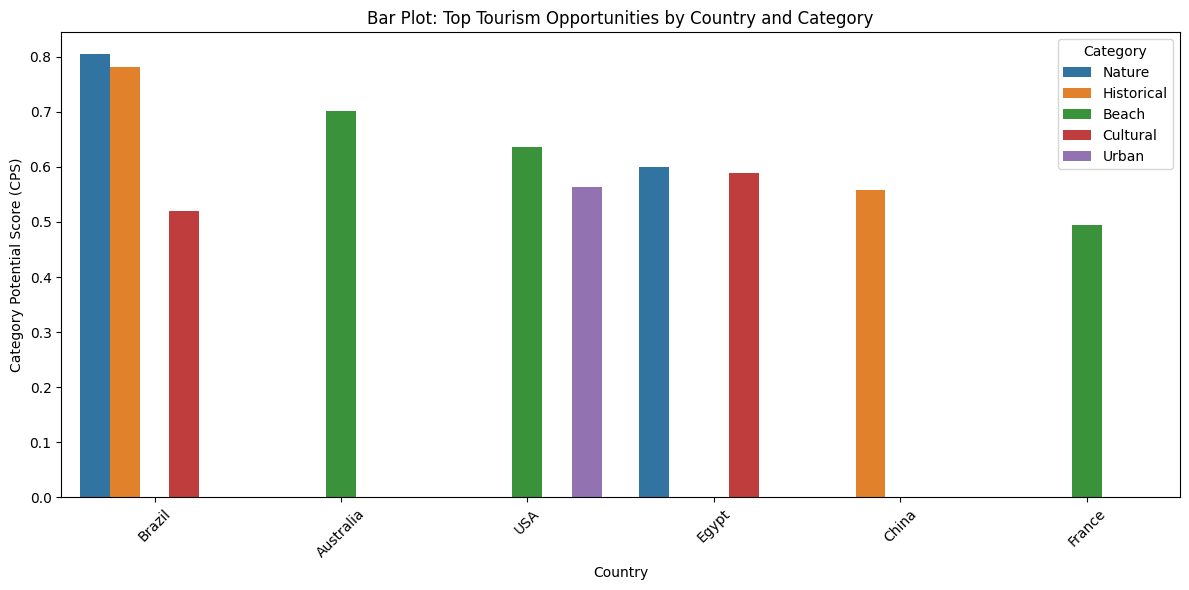

In [42]:
# 2. Bar Plot: CPS by Country and Category
plt.figure(figsize=(12, 6))
sns.barplot(data=recommendation_table, x='Country', y='Potential Score (CPS)', hue='Tourism Category')
plt.title('Bar Plot: Top Tourism Opportunities by Country and Category')
plt.ylabel('Category Potential Score (CPS)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

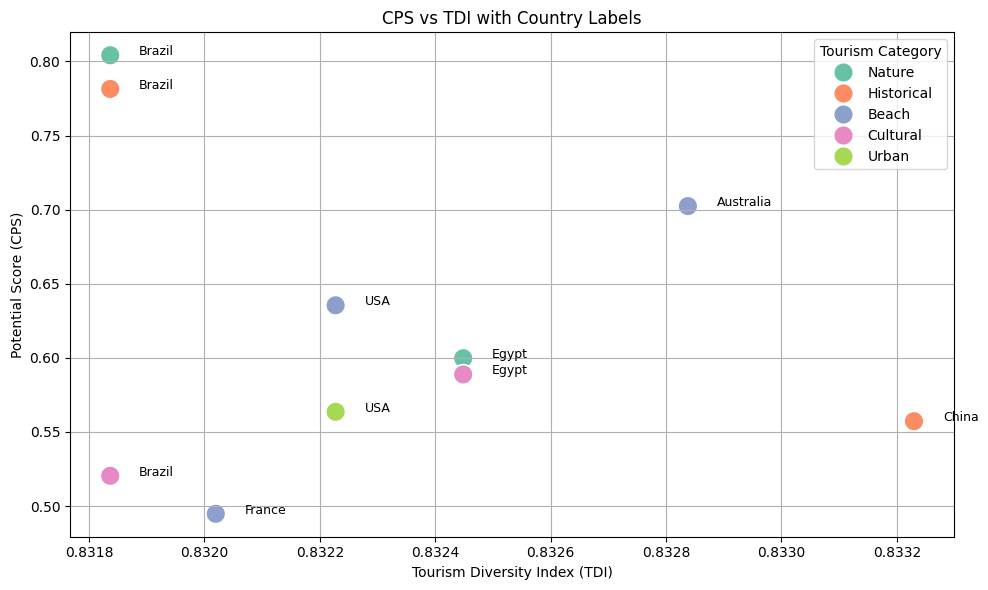

In [43]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=recommendation_table,
    x='Tourism Diversity Index (TDI)',
    y='Potential Score (CPS)',
    hue='Tourism Category',
    palette='Set2',
    s=200  # fixed bubble size
)

# Add country labels on each bubble
for i in range(recommendation_table.shape[0]):
    country = recommendation_table.iloc[i]['Country']
    tdi = recommendation_table.iloc[i]['Tourism Diversity Index (TDI)']
    cps = recommendation_table.iloc[i]['Potential Score (CPS)']
    plt.text(tdi + 0.00005, cps, country, fontsize=9)

plt.title('CPS vs TDI with Country Labels')
plt.xlabel('Tourism Diversity Index (TDI)')
plt.ylabel('Potential Score (CPS)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Recalculate TDI
def calculate_tdi(data):
    tdi_scores = {}
    for country in data['Country'].unique():
        subset = data[data['Country'] == country]
        proportions = subset['Category'].value_counts(normalize=True)
        si_squared = (proportions**2).sum()
        tdi_scores[country] = 1 - si_squared
    return pd.DataFrame.from_dict(tdi_scores, orient='index', columns=['TDI']).reset_index().rename(columns={'index': 'Country'})

tdi_df = calculate_tdi(df)

# Precompute revenue per visitor
df['Revenue_per_visitor'] = df['Revenue'] / df['Visitors']

# Group by Country + Category
grouped = df.groupby(['Country', 'Category']).agg({
    'Revenue_per_visitor': 'mean',
    'Rating': 'mean',
    'Accommodation_Available': 'mean',
    'Visitors': 'sum',
    'Revenue': 'sum'
}).reset_index()

# Normalize features for CPS
for col in ['Revenue_per_visitor', 'Rating', 'Accommodation_Available']:
    grouped[col + '_norm'] = (grouped[col] - grouped[col].min()) / (grouped[col].max() - grouped[col].min())

# Compute CPS
grouped['CPS'] = grouped[['Revenue_per_visitor_norm', 'Rating_norm', 'Accommodation_Available_norm']].mean(axis=1)

# Merge with TDI
merged_df = pd.merge(grouped, tdi_df, on='Country', how='left')

# Add count of records
counts = df.groupby(['Country', 'Category']).size().reset_index(name='Record_Count')
merged_df = pd.merge(merged_df, counts, on=['Country', 'Category'])

# Rename for Tableau compatibility
merged_df = merged_df.rename(columns={
    'Revenue_per_visitor': 'Revenue per Visitor',
    'Accommodation_Available': 'Accommodation Availability Rate',
    'Rating': 'Average Rating',
    'Revenue': 'Total Revenue',
    'Visitors': 'Total Visitors'
})

# Preview
merged_df.head()

#Save to CSV file
merged_df.to_csv("Final_datset.csv", index=False)

In [45]:
import plotly.express as px

# Aggregate to country-level: one TDI score per country
tdi_country_map = merged_df[['Country', 'TDI']].drop_duplicates()

# Plot TDI on a world map
fig = px.choropleth(
    tdi_country_map,
    locations="Country",
    locationmode="country names",
    color="TDI",
    hover_name="Country",
    color_continuous_scale="YlGnBu",
    title="Tourism Diversity Index (TDI) by Country"
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
fig.write_html("TDI_World_Map.html")

In [46]:
from scipy.stats import pearsonr, ttest_ind
import pandas as pd

results = {}

# 1. H1: Countries with higher Tourism Diversity Index have higher revenue
tdi_revenue = merged_df.groupby("Country")[["TDI", "Total Revenue"]].mean().dropna()
corr1, pval1 = pearsonr(tdi_revenue["TDI"], tdi_revenue["Total Revenue"])
results["TDI vs Revenue (Pearson)"] = {"Correlation": corr1, "P-Value": pval1}

# 2. H2: High-rated but low-representation categories are market gaps
median_count = merged_df["Record_Count"].median()
high_rating = merged_df[merged_df["Average Rating"] >= 3.5]
low_rep = high_rating[high_rating["Record_Count"] < median_count]["CPS"]
high_rep = high_rating[high_rating["Record_Count"] >= median_count]["CPS"]
if len(low_rep) > 1 and len(high_rep) > 1:
    tstat, pval2 = ttest_ind(low_rep, high_rep, equal_var=False)
    results["High Rating, Low Representation vs CPS (T-test)"] = {"T-Statistic": tstat, "P-Value": pval2}
else:
    results["High Rating, Low Representation vs CPS (T-test)"] = {"T-Statistic": None, "P-Value": "Insufficient data"}

# 3. H3: Fewer accommodations with high visitors = unmet need
acc_vis = merged_df.groupby("Country")[["Accommodation Availability Rate", "Total Visitors"]].mean().dropna()
corr3, pval3 = pearsonr(acc_vis["Accommodation Availability Rate"], acc_vis["Total Visitors"])
results["Accommodation vs Visitors (Pearson)"] = {"Correlation": corr3, "P-Value": pval3}

# 4. H4: CPS correlates with growth potential (Revenue per Visitor as proxy)
corr4, pval4 = pearsonr(merged_df["CPS"], merged_df["Revenue per Visitor"])
results["CPS vs Revenue per Visitor (Pearson)"] = {"Correlation": corr4, "P-Value": pval4}

# Convert results to DataFrame
stats_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Hypothesis"})
display(stats_df)

,Hypothesis,Correlation,P-Value,T-Statistic
0,TDI vs Revenue (Pearson),-0.094489,0.840305,NaN
1,"High Rating, Low Representation vs CPS (T-test)",NaN,Insufficient data,None
2,Accommodation vs Visitors (Pearson),0.155252,0.739601,NaN
3,CPS vs Revenue per Visitor (Pearson),0.676959,0.000001,NaN


In [47]:
print("Low representation group size:", len(low_rep))
print("High representation group size:", len(high_rep))
print("Low CPS values:\n", low_rep)
print("High CPS values:\n", high_rep)

Low representation group size: 0
High representation group size: 0
Low CPS values:
 Series([], Name: CPS, dtype: float64)
High CPS values:
 Series([], Name: CPS, dtype: float64)


In [48]:
import pandas as pd
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu

# Drop missing values to avoid errors
subset = merged_df.dropna(subset=["TDI", "Total Revenue", "Average Rating", "CPS", "Record_Count", "Accommodation Availability Rate", "Total Visitors", "Revenue per Visitor"])

# --- Hypothesis 1: TDI vs Total Revenue ---
tdi_revenue = subset.groupby("Country")[["TDI", "Total Revenue"]].mean()
corr1, pval1 = pearsonr(tdi_revenue["TDI"], tdi_revenue["Total Revenue"])

# --- Hypothesis 2: High rating, low representation vs CPS ---
rating_median = subset["Average Rating"].median()
count_median = subset["Record_Count"].median()

low_rep_high_rating = subset[
    (subset["Average Rating"] >= rating_median) & 
    (subset["Record_Count"] < count_median)
]["CPS"]

high_rep_high_rating = subset[
    (subset["Average Rating"] >= rating_median) & 
    (subset["Record_Count"] >= count_median)
]["CPS"]

# Perform T-test
if len(low_rep_high_rating) > 1 and len(high_rep_high_rating) > 1:
    t_stat, t_pval = ttest_ind(low_rep_high_rating, high_rep_high_rating, equal_var=False)
else:
    t_stat, t_pval = None, "Insufficient data"

# Perform Mann–Whitney U test
if len(low_rep_high_rating) > 1 and len(high_rep_high_rating) > 1:
    u_stat, u_pval = mannwhitneyu(low_rep_high_rating, high_rep_high_rating, alternative='two-sided')
else:
    u_stat, u_pval = None, "Insufficient data"

# --- Hypothesis 3: Accommodation vs Visitors ---
acc_vis = subset.groupby("Country")[["Accommodation Availability Rate", "Total Visitors"]].mean()
corr3, pval3 = pearsonr(acc_vis["Accommodation Availability Rate"], acc_vis["Total Visitors"])

# --- Hypothesis 4: CPS vs Revenue per Visitor ---
corr4, pval4 = pearsonr(subset["CPS"], subset["Revenue per Visitor"])

# --- Summary Output ---
print("Hypothesis 1: TDI vs Revenue")
print(" Pearson Correlation:", corr1)
print(" P-Value:", pval1)

print("\nHypothesis 2: High Rating + Low Representation vs CPS")
print(" T-Test Statistic:", t_stat)
print(" T-Test P-Value:", t_pval)
print(" Mann–Whitney U-Statistic:", u_stat)
print(" Mann–Whitney P-Value:", u_pval)

print("\nHypothesis 3: Accommodation Availability vs Visitors")
print(" Pearson Correlation:", corr3)
print(" P-Value:", pval3)

print("\nHypothesis 4: CPS vs Revenue per Visitor")
print(" Pearson Correlation:", corr4)
print(" P-Value:", pval4)

Hypothesis 1: TDI vs Revenue
 Pearson Correlation: -0.09448942684578737
 P-Value: 0.840304898343727

Hypothesis 2: High Rating + Low Representation vs CPS
 T-Test Statistic: 1.107226047228351
 T-Test P-Value: 0.28538925879583155
 Mann–Whitney U-Statistic: 71.0
 Mann–Whitney P-Value: 0.24095466870157023

Hypothesis 3: Accommodation Availability vs Visitors
 Pearson Correlation: 0.15525197115446046
 P-Value: 0.7396009143798645

Hypothesis 4: CPS vs Revenue per Visitor
 Pearson Correlation: 0.6769593289380678
 P-Value: 8.545364446315876e-07


## 📊 Hypothesis Testing Summary

### Hypothesis 1: $TDI \rightarrow \text{Total Revenue}$
- Pearson Correlation: $-0.094$
- $p = 0.840$

**Conclusion**: There is no statistically significant relationship between Tourism Diversity Index (TDI) and total revenue.  
$\Rightarrow$ We **reject the hypothesis** and accept the alternative: TDI does **not** strongly correlate with revenue.

---

### Hypothesis 2: High Rating + Low Representation $\rightarrow$ High CPS
- Welch’s $t$-test: $t = 1.107$, $p = 0.285$
- Mann–Whitney $U$ test: $U = 71.0$, $p = 0.241$

**Conclusion**: Both parametric and non-parametric tests show no significant difference in CPS between high-rated low-representation and high-representation categories.  
$\Rightarrow$ The **alternative hypothesis holds**: high-rated categories may already be saturated.

---

### Hypothesis 3: Accommodation Availability $\rightarrow$ Total Visitors
- Pearson Correlation: $0.155$
- $p = 0.740$

**Conclusion**: No statistically significant link between accommodation availability and visitor volume.  
$\Rightarrow$ We **reject the hypothesis**: accommodation access does **not** meaningfully affect tourism volume.

---

### Hypothesis 4: CPS $\rightarrow$ Revenue per Visitor
- Pearson Correlation: $0.677$
- $p < 0.000001$

**Conclusion**: Strong positive correlation between Category Potential Score (CPS) and revenue per visitor.  
$\Rightarrow$ We **accept the hypothesis**: CPS is a reliable indicator of tourism growth potential.

---

In [53]:
# Define thresholds
tdi_threshold = merged_df["TDI"].median()
cps_threshold = merged_df["CPS"].quantile(0.75)
count_threshold = merged_df["Record_Count"].quantile(0.3)

# Filter for high-opportunity recommendations
recommendations = merged_df[
    (merged_df["TDI"] >= tdi_threshold) &
    (merged_df["CPS"] >= cps_threshold) &
    (merged_df["Record_Count"] <= count_threshold)
].copy()

# Sort for clarity
recommendations = recommendations.sort_values(by=["Country", "CPS"], ascending=[True, False])

# Optional: pick top 2 categories per country
top_n = 2
recommendations = recommendations.groupby("Country").head(top_n).reset_index(drop=True)

# Display or save
print(recommendations[["Country", "Category", "CPS", "TDI", "Record_Count"]])

  Country    Category       CPS       TDI  Record_Count
0   China  Historical  0.557252  0.833230           135
1   China      Nature  0.474909  0.833230           133
2   Egypt      Nature  0.599743  0.832448           129


In [50]:
# Unique category options from the dataset
available_categories = merged_df["Category"].dropna().unique().tolist()

# Display numbered options
print("Available Tourism Categories:")
for i, cat in enumerate(available_categories, 1):
    print(f"{i}. {cat}")

# User selects a number
choice = int(input("\nEnter the number of your chosen category: "))

# Validate and get the selected category
if 1 <= choice <= len(available_categories):
    selected_category = available_categories[choice - 1]
    print(f"\nYou selected: {selected_category}")
else:
    raise ValueError("Invalid selection. Please run again and choose a valid number.")

# Recommendation logic
def recommend_by_category(category_input, df, min_tdi=0.75, min_cps=0.5):
    return df[
        (df["Category"].str.lower() == category_input.lower()) &
        (df["TDI"] >= min_tdi) &
        (df["CPS"] >= min_cps)
    ][["Country", "Category", "CPS", "TDI", "Record_Count"]].sort_values(by="CPS", ascending=False)

# Get and display recommendations
recommendations = recommend_by_category(selected_category, merged_df)

if recommendations.empty:
    print("No strong recommendations found.")
else:
    print("\nTop Recommended Countries:")
    print(recommendations)

Available Tourism Categories:
1. Adventure
2. Beach
3. Cultural
4. Historical
5. Nature
6. Urban

You selected: Historical

Top Recommended Countries:
   Country    Category       CPS       TDI  Record_Count
9   Brazil  Historical  0.781434  0.831837           148
15   China  Historical  0.557252  0.833230           135


## Recommendation System Summary

### 1. Top-N Country-Wise Recommendation System

This system identifies the most promising tourism categories **within each country** by applying strategic thresholds:

- **Threshold Definitions:**
  - Median TDI: \( TDI_{threshold} = \text{median}(TDI) \)
  - 75th Percentile CPS: \( CPS_{threshold} = Q_3(CPS) \)
  - 30th Percentile Record Count: \( Count_{threshold} = Q_1(Record\_Count) \)

- **Selection Criteria:**
  - \( TDI \geq TDI_{threshold} \)
  - \( CPS \geq CPS_{threshold} \)
  - \( Record\_Count \leq Count_{threshold} \)

- **Post-Filtering Logic:**
  - Sorted by country and CPS
  - Top 5 categories per country are returned

- **Use Case:**
  - Useful for identifying underrepresented, high-potential tourism segments in each country

---

### 2. Interactive Category-Based Recommendation Engine

This system allows a user to **select a tourism category** and retrieves countries that offer the strongest potential in that domain:

- **Input:**  
  One of the following categories:
  - Adventure, Beach, Cultural, Historical, Nature, Urban

- **Filtering Criteria:**
  - \( TDI \geq 0.75 \)
  - \( CPS \geq 0.5 \)
  - Category matches user input (case-insensitive)

- **Output:**
  - A sorted table of countries with highest CPS values in that category

- **Use Case:**
  - Helps tourists, planners, and entrepreneurs identify countries that are especially promising in specific tourism categories

---